In [1]:
from EmuLP import Cosmology, Filter, Galaxy, Estimator, Extinction, Template, Analysis

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import jax_cosmo as jc
import jax.numpy as jnp
from jax import vmap, jit
import json, pickle
import os,sys,copy
from tqdm import tqdm
from collections import namedtuple

from scipy.interpolate import interp1d
from jax_cosmo.scipy.interpolate import InterpolatedUnivariateSpline as j_spline

2023-11-15 11:59:21.428199: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/nvptx_compiler.cc:497] The NVIDIA driver's CUDA version is 11.3 which is older than the ptxas CUDA version (11.4.152). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
os.getcwd()

'/sps/lsst/groups/photoz/jocheval/PhotoZ_PhD'

In [3]:
ref_json = 'EmuLP/COSMOS2020-with-FORS2-HSC_only-jax-CC-togglePriorTrue-opa-fullAnalysis.json' # attention à la localisation du fichier !
test_conf_json = 'EmuLP/COSMOS2020-with-FORS2-HSC_only-jax-CC-prior-full-KinCalClusTemp_priorEBV_noTypeNoLaw.json' # attention à la localisation du fichier !
#conf_json = 'EmuLP/COSMOS2020-with-FORS2-HSC_only-jax-CC-prior-full-dustSelTemp_priorEBV.json' # attention à la localisation du fichier !
ref_inputs = Analysis.json_to_inputs(ref_json)
test_inputs = Analysis.json_to_inputs(test_conf_json)

In [4]:
os.getcwd()

'/sps/lsst/groups/photoz/jocheval/PhotoZ_PhD'

In [5]:
cosmo_ref, z_grid_ref, fine_z_grid_ref, wl_grid_ref, filters_arr_ref, named_filts_ref, baseTemp_arr_ref, extlaws_dict_ref,\
ebv_vals_ref, dust_arr_ref, wls_opa_ref, opa_zgrid_ref, opacity_grid_ref, obs_arr_ref = Analysis.load_data_for_analysis(os.path.basename(ref_json))

Loading filters :


100%|██████████| 7/7 [00:00<00:00, 63.11it/s]


Building templates :


100%|██████████| 29/29 [00:04<00:00,  7.22it/s]


Generating dust attenuations laws :


100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


Loading IGM attenuations :
Loading observations :


100%|██████████| 1000/1000 [00:00<00:00, 1142.71it/s]


In [6]:
cosmo_test, z_grid_test, fine_z_grid_test, wl_grid_test, filters_arr_test, named_filts_test, baseTemp_arr_test, extlaws_dict_test,\
ebv_vals_test, dust_arr_test, wls_opa_test, opa_zgrid_test, opacity_grid_test, obs_arr_test = Analysis.load_data_for_analysis(os.path.basename(test_conf_json))

Loading filters :


100%|██████████| 7/7 [00:00<00:00, 78.48it/s]


Building templates :


100%|██████████| 29/29 [00:02<00:00, 11.57it/s]


Generating dust attenuations laws :


100%|██████████| 10/10 [00:00<00:00, 291.64it/s]

100%|██████████| 2/2 [00:00<00:00, 25.48it/s]


Loading IGM attenuations :
Loading observations :


100%|██████████| 1000/1000 [00:00<00:00, 1366.66it/s]


In [7]:
os.getcwd()

'/sps/lsst/groups/photoz/jocheval/PhotoZ_PhD'

In [8]:
df_ref_emulp = pd.read_pickle(f"{ref_inputs['run name']}_results_summary.pkl")
df_ref_emulp

,Id,Photometric redshift,True redshift,Template SED,Extinction law,E(B-V),Chi2,Highest evidence SED,Highest evidence dust law,Highest evidence E(B-V),Highest evidence odd ratio,Highest evidence z_phot (mode),Highest evidence z_phot (mean),Highest evidence sigma(z),Best SED at z_spec,Best dust law at z_spec,E(B-V) at z_spec,Mode of best model at z_spec,Mean of best model at z_spec,Odd ratio of best model at z_spec
0,362.0,0.61,0.6636,CWW_Im-id546,Prevot,0.25,22.885651,CWW_Im-id546,Prevot,0.25,1.000000,0.61,0.613186,0.000299,CWW_Im-id546,Prevot,0.25,0.61,0.613186,1.000000e+00
1,8353.0,0.27,0.2819,CWW_Scd-id354,Calzetti,0.15,124.263847,CWW_Scd-id354,Calzetti,0.15,1.000000,0.27,0.269855,0.000003,CWW_Scd-id354,Calzetti,0.15,0.27,0.269855,1.000000e+00
2,7547.0,0.21,0.2215,CWW_Im-id537,Prevot,0.20,73.361610,CWW_Im-id537,Prevot,0.20,1.000000,0.21,0.211476,0.000032,CWW_Im-id537,Prevot,0.20,0.21,0.211476,1.000000e+00
3,10402.0,0.65,0.6595,CWW_Im-id113,Prevot,0.20,16.253048,CWW_Im-id113,Prevot,0.20,1.000000,0.65,0.644358,0.000396,CWW_Im-id113,Prevot,0.20,0.65,0.644358,1.000000e+00
4,12425.0,1.35,1.0201,CWW_Scd-id532,Prevot,0.20,25.719025,CWW_Scd-id532,Prevot,0.20,1.000000,1.35,1.346265,0.000578,CWW_Im-id344,Prevot,0.25,0.77,0.926751,7.343536e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,5756.0,2.45,2.6639,CWW_Im-id699,Calzetti,0.30,27.289156,CWW_Im-id265,Prevot,0.10,1.026272,2.35,2.377516,0.003181,CWW_Im-id699,Calzetti,0.25,2.65,2.654064,3.678171e-01
996,16455.0,0.73,0.7336,CWW_E-id235,Calzetti,0.10,6.527909,CWW_E-id235,Calzetti,0.10,1.000000,0.73,0.731324,0.000025,CWW_E-id235,Calzetti,0.10,0.73,0.731324,1.000000e+00
997,13692.0,0.63,0.9258,CWW_Scd-id268,Prevot,0.05,24.314442,CWW_Scd-id268,Prevot,0.05,1.000000,0.63,0.630095,0.000112,CWW_Im-id537,Prevot,0.25,0.89,0.891429,3.305564e-07
998,3751.0,0.87,0.8700,CWW_Im-id113,Prevot,0.15,30.635420,CWW_Im-id113,Prevot,0.15,1.000000,0.87,0.859542,0.000266,CWW_Im-id113,Prevot,0.15,0.87,0.859542,1.000000e+00


In [9]:
df_test_emulp = pd.read_pickle(f"{test_inputs['run name']}_results_summary.pkl")
df_test_emulp

,Id,Photometric redshift,True redshift,Template SED,Extinction law,E(B-V),Chi2,Highest evidence SED,Highest evidence dust law,Highest evidence E(B-V),Highest evidence odd ratio,Highest evidence z_phot (mode),Highest evidence z_phot (mean),Highest evidence sigma(z),Best SED at z_spec,Best dust law at z_spec,E(B-V) at z_spec,Mode of best model at z_spec,Mean of best model at z_spec,Odd ratio of best model at z_spec
0,362.0,0.61,0.6636,CWW_Im-id546,Prevot,0.25,20.912914,CWW_Im-id546,Prevot,0.25,1.0,0.61,0.613186,0.000299,CWW_Im-id546,Prevot,0.25,0.61,0.613186,1.000000e+00
1,8353.0,0.27,0.2819,CWW_Scd-id354,Calzetti,0.15,122.422340,CWW_Scd-id354,Calzetti,0.15,1.0,0.27,0.269855,0.000003,CWW_Scd-id354,Calzetti,0.15,0.27,0.269855,1.000000e+00
2,7547.0,0.21,0.2215,CWW_Im-id537,Prevot,0.20,70.900551,CWW_Im-id537,Prevot,0.20,1.0,0.21,0.211476,0.000032,CWW_Im-id537,Prevot,0.20,0.21,0.211476,1.000000e+00
3,10402.0,0.65,0.6595,CWW_Im-id113,Prevot,0.20,13.791986,CWW_Im-id113,Prevot,0.20,1.0,0.65,0.644358,0.000396,CWW_Im-id113,Prevot,0.20,0.65,0.644358,9.999999e-01
4,12425.0,1.35,1.0201,CWW_Scd-id532,Prevot,0.20,23.257961,CWW_Scd-id532,Prevot,0.20,1.0,1.35,1.346265,0.000578,CWW_Im-id344,Prevot,0.25,0.77,0.926751,5.752638e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,5756.0,2.35,2.6639,CWW_Im-id265,Prevot,0.10,25.361845,CWW_Im-id265,Prevot,0.10,1.0,2.35,2.377516,0.003181,CWW_Im-id699,Calzetti,0.25,2.65,2.654064,3.193316e-01
996,16455.0,0.73,0.7336,CWW_E-id235,Calzetti,0.10,4.324327,CWW_E-id235,Calzetti,0.10,1.0,0.73,0.731324,0.000025,CWW_E-id235,Calzetti,0.10,0.73,0.731324,1.000000e+00
997,13692.0,0.63,0.9258,CWW_Scd-id268,Prevot,0.05,21.110231,CWW_Scd-id268,Prevot,0.05,1.0,0.63,0.630095,0.000112,CWW_Im-id537,Prevot,0.25,0.89,0.891429,1.785807e-07
998,3751.0,0.87,0.8700,CWW_Im-id113,Prevot,0.15,28.793911,CWW_Im-id113,Prevot,0.15,1.0,0.87,0.859542,0.000266,CWW_Im-id113,Prevot,0.15,0.87,0.859542,1.000000e+00


In [10]:
df_ref_more, outl_rate_ref, NMAD_ref = Analysis.results_in_dataframe(ref_json, obs_arr_ref, named_filts_ref)
df_ref_more

100%|██████████| 1000/1000 [00:19<00:00, 50.70it/s]


Outlier rate = 12.8257% ; NMAD = 0.06142


,Id,Photometric redshift,True redshift,Template SED,Extinction law,E(B-V),Chi2,Highest evidence SED,Highest evidence dust law,Highest evidence E(B-V),...,MagAB(hsc_iHSC),err_MagAB(hsc_iHSC),MagAB(hsc_zHSC),err_MagAB(hsc_zHSC),MagAB(hsc_yHSC),err_MagAB(hsc_yHSC),bias,Outlier,U-B,R-I
0,362.0,0.61,0.6636,CWW_Im-id546,Prevot,0.25,22.885651,CWW_Im-id546,Prevot,0.25,...,21.724495,0.005330,21.681114,0.006234,21.581612,0.007518,-5.360005e-02,False,0.455261,0.429222
1,8353.0,0.27,0.2819,CWW_Scd-id354,Calzetti,0.15,124.263847,CWW_Scd-id354,Calzetti,0.15,...,19.593529,0.002292,19.379829,0.002413,19.226929,0.002557,-1.190002e-02,False,0.858223,0.419388
2,7547.0,0.21,0.2215,CWW_Im-id537,Prevot,0.20,73.361610,CWW_Im-id537,Prevot,0.20,...,20.448967,0.003380,20.397652,0.003857,20.312340,0.004316,-1.150001e-02,False,0.732582,0.199509
3,10402.0,0.65,0.6595,CWW_Im-id113,Prevot,0.20,16.253048,CWW_Im-id113,Prevot,0.20,...,22.066360,0.007630,21.858215,0.008252,21.678215,0.009633,-9.500024e-03,False,0.587463,0.611992
4,12425.0,1.35,1.0201,CWW_Scd-id532,Prevot,0.20,25.719025,CWW_Scd-id532,Prevot,0.20,...,23.027916,0.011093,22.694069,0.011409,22.185799,0.011367,3.298999e-01,True,0.492928,0.423218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,5756.0,2.45,2.6639,CWW_Im-id699,Calzetti,0.30,27.289156,CWW_Im-id265,Prevot,0.10,...,23.831917,0.014877,23.791687,0.019078,23.761284,0.029802,-2.139000e-01,False,0.890648,0.072914
996,16455.0,0.73,0.7336,CWW_E-id235,Calzetti,0.10,6.527909,CWW_E-id235,Calzetti,0.10,...,20.603783,0.003643,20.173088,0.003468,19.879967,0.003540,-3.600041e-03,False,1.876450,1.335739
997,13692.0,0.63,0.9258,CWW_Scd-id268,Prevot,0.05,24.314442,CWW_Scd-id268,Prevot,0.05,...,21.630302,0.005108,21.311661,0.005163,21.131180,0.005704,-2.958000e-01,True,0.354195,0.752411
998,3751.0,0.87,0.8700,CWW_Im-id113,Prevot,0.15,30.635420,CWW_Im-id113,Prevot,0.15,...,21.752357,0.005474,21.451469,0.005597,21.319901,0.006395,-5.483627e-08,False,0.378319,0.734573


In [11]:
df_test_more, outl_rate_test, NMAD_test = Analysis.results_in_dataframe(test_conf_json, obs_arr_test, named_filts_test)
df_test_more

100%|██████████| 1000/1000 [00:19<00:00, 50.91it/s]


Outlier rate = 12.3246% ; NMAD = 0.06364


,Id,Photometric redshift,True redshift,Template SED,Extinction law,E(B-V),Chi2,Highest evidence SED,Highest evidence dust law,Highest evidence E(B-V),...,MagAB(hsc_iHSC),err_MagAB(hsc_iHSC),MagAB(hsc_zHSC),err_MagAB(hsc_zHSC),MagAB(hsc_yHSC),err_MagAB(hsc_yHSC),bias,Outlier,U-B,R-I
0,362.0,0.61,0.6636,CWW_Im-id546,Prevot,0.25,20.912914,CWW_Im-id546,Prevot,0.25,...,21.724495,0.005330,21.681114,0.006234,21.581612,0.007518,-5.360005e-02,False,0.455261,0.429222
1,8353.0,0.27,0.2819,CWW_Scd-id354,Calzetti,0.15,122.422340,CWW_Scd-id354,Calzetti,0.15,...,19.593529,0.002292,19.379829,0.002413,19.226929,0.002557,-1.190002e-02,False,0.858223,0.419388
2,7547.0,0.21,0.2215,CWW_Im-id537,Prevot,0.20,70.900551,CWW_Im-id537,Prevot,0.20,...,20.448967,0.003380,20.397652,0.003857,20.312340,0.004316,-1.150001e-02,False,0.732582,0.199509
3,10402.0,0.65,0.6595,CWW_Im-id113,Prevot,0.20,13.791986,CWW_Im-id113,Prevot,0.20,...,22.066360,0.007630,21.858215,0.008252,21.678215,0.009633,-9.500024e-03,False,0.587463,0.611992
4,12425.0,1.35,1.0201,CWW_Scd-id532,Prevot,0.20,23.257961,CWW_Scd-id532,Prevot,0.20,...,23.027916,0.011093,22.694069,0.011409,22.185799,0.011367,3.298999e-01,True,0.492928,0.423218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,5756.0,2.35,2.6639,CWW_Im-id265,Prevot,0.10,25.361845,CWW_Im-id265,Prevot,0.10,...,23.831917,0.014877,23.791687,0.019078,23.761284,0.029802,-3.139001e-01,False,0.890648,0.072914
996,16455.0,0.73,0.7336,CWW_E-id235,Calzetti,0.10,4.324327,CWW_E-id235,Calzetti,0.10,...,20.603783,0.003643,20.173088,0.003468,19.879967,0.003540,-3.600041e-03,False,1.876450,1.335739
997,13692.0,0.63,0.9258,CWW_Scd-id268,Prevot,0.05,21.110231,CWW_Scd-id268,Prevot,0.05,...,21.630302,0.005108,21.311661,0.005163,21.131180,0.005704,-2.958000e-01,True,0.354195,0.752411
998,3751.0,0.87,0.8700,CWW_Im-id113,Prevot,0.15,28.793911,CWW_Im-id113,Prevot,0.15,...,21.752357,0.005474,21.451469,0.005597,21.319901,0.006395,-5.483627e-08,False,0.378319,0.734573


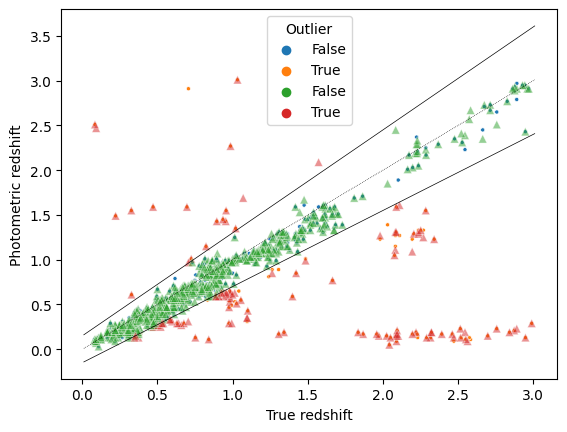

In [12]:
f,a=plt.subplots(1,1)
sns.scatterplot(data=df_ref_more, x='True redshift', y='Photometric redshift', hue='Outlier', marker='.', ax=a)
sns.scatterplot(data=df_test_more, x='True redshift', y='Photometric redshift', hue='Outlier', marker='^', alpha=0.5,\
                palette={True:'tab:red', False:'tab:green'}, ax=a)
a.plot(z_grid_ref, z_grid_ref, c='k', ls=':', lw=0.5)
a.plot(z_grid_ref, 0.15+1.15*z_grid_ref, c='k', lw=0.5)
a.plot(z_grid_ref, -0.15+0.85*z_grid_ref, c='k', lw=0.5)

In [13]:
with open(f"{ref_inputs['run name']}_posteriors_dict.pkl", 'rb') as handle:
    posteriors_dict_ref=pickle.load(handle)
with open(f"{test_inputs['run name']}_posteriors_dict.pkl", 'rb') as handle:
    posteriors_dict_test=pickle.load(handle)

In [14]:
_sel = (np.abs(df_test_more['bias']) < np.abs(df_ref_more['bias']))
sel_ref_df = df_ref_more[_sel]
sel_test_df = df_test_more[_sel]
sel_test_df

,Id,Photometric redshift,True redshift,Template SED,Extinction law,E(B-V),Chi2,Highest evidence SED,Highest evidence dust law,Highest evidence E(B-V),...,MagAB(hsc_iHSC),err_MagAB(hsc_iHSC),MagAB(hsc_zHSC),err_MagAB(hsc_zHSC),MagAB(hsc_yHSC),err_MagAB(hsc_yHSC),bias,Outlier,U-B,R-I
9,1756.0,0.69,0.7450,CWW_Scd-id45,Calzetti,0.20,35.777260,CWW_Scd-id45,Calzetti,0.20,...,20.737572,0.004075,20.384949,0.004037,20.139656,0.004205,-0.0550,False,0.754272,0.967415
19,9779.0,1.01,1.0412,CWW_Im-id113,Calzetti,0.20,28.084959,CWW_Im-id113,Calzetti,0.20,...,23.980263,0.015741,23.546104,0.015499,23.283485,0.019126,-0.0312,False,0.327072,0.645691
50,13017.0,0.67,0.7389,CWW_Im-id113,Calzetti,0.00,27.766617,CWW_Im-id113,Prevot,0.00,...,21.825554,0.006082,21.655983,0.006690,21.679893,0.008621,-0.0689,False,0.170288,0.441353
68,16724.0,1.31,2.0829,CWW_Scd-id45,Prevot,0.20,33.321407,CWW_Scd-id45,Prevot,0.20,...,24.244049,0.026557,23.502815,0.021867,22.938934,0.023214,-0.7729,True,0.420341,0.578423
77,366.0,0.57,0.6232,CWW_Scd-id45,Calzetti,0.30,19.469788,CWW_Scd-id45,Calzetti,0.30,...,21.341721,0.004596,20.922623,0.004419,20.688644,0.004770,-0.0532,False,1.129486,0.875992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
959,9944.0,2.33,2.2290,CWW_Im-id546,Prevot,0.05,25.973288,CWW_Im-id699,Calzetti,0.20,...,24.379059,0.020710,24.362709,0.027511,24.406013,0.048626,0.1010,False,0.575539,0.043915
962,11808.0,0.33,0.3117,CWW_Im-id87,Prevot,0.05,27.414179,CWW_Im-id87,Prevot,0.05,...,24.509888,0.027281,24.259003,0.031783,24.335014,0.058215,0.0183,False,0.359428,0.042686
973,5054.0,0.69,0.6167,CWW_Scd-id354,Prevot,0.20,20.791035,CWW_Scd-id354,Prevot,0.20,...,21.931969,0.006248,21.581474,0.006251,21.420570,0.007116,0.0733,False,0.449448,0.919685
981,234.0,0.21,0.2190,CWW_Scd-id45,Calzetti,0.25,9.313285,CWW_Scd-id45,Calzetti,0.25,...,20.629814,0.004190,20.360825,0.004336,20.198349,0.004879,-0.0090,False,1.441483,0.478653


In [15]:
sel_ref_df

,Id,Photometric redshift,True redshift,Template SED,Extinction law,E(B-V),Chi2,Highest evidence SED,Highest evidence dust law,Highest evidence E(B-V),...,MagAB(hsc_iHSC),err_MagAB(hsc_iHSC),MagAB(hsc_zHSC),err_MagAB(hsc_zHSC),MagAB(hsc_yHSC),err_MagAB(hsc_yHSC),bias,Outlier,U-B,R-I
9,1756.0,0.65,0.7450,CWW_Scd-id354,Prevot,0.30,36.921326,CWW_Scd-id354,Prevot,0.30,...,20.737572,0.004075,20.384949,0.004037,20.139656,0.004205,-0.0950,False,0.754272,0.967415
19,9779.0,0.65,1.0412,CWW_Im-id344,Prevot,0.30,29.558228,CWW_Im-id344,Prevot,0.30,...,23.980263,0.015741,23.546104,0.015499,23.283485,0.019126,-0.3912,True,0.327072,0.645691
50,13017.0,0.59,0.7389,AVG_CLUST_CWW_Im,Prevot,0.10,30.840328,AVG_CLUST_CWW_Im,Prevot,0.10,...,21.825554,0.006082,21.655983,0.006690,21.679893,0.008621,-0.1489,False,0.170288,0.441353
68,16724.0,1.27,2.0829,CWW_Scd-id354,Prevot,0.35,33.808792,CWW_Scd-id532,Prevot,0.40,...,24.244049,0.026557,23.502815,0.021867,22.938934,0.023214,-0.8129,True,0.420341,0.578423
77,366.0,0.43,0.6232,CWW_Scd-id532,Prevot,0.50,15.016966,CWW_Scd-id532,Prevot,0.50,...,21.341721,0.004596,20.922623,0.004419,20.688644,0.004770,-0.1932,False,1.129486,0.875992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
959,9944.0,0.17,2.2290,CWW_Im-id699,Calzetti,0.20,28.684690,CWW_Im-id699,Calzetti,0.20,...,24.379059,0.020710,24.362709,0.027511,24.406013,0.048626,-2.0590,True,0.575539,0.043915
962,11808.0,0.35,0.3117,CWW_Im-id546,Calzetti,0.20,30.522713,CWW_Im-id87,Prevot,0.05,...,24.509888,0.027281,24.259003,0.031783,24.335014,0.058215,0.0383,False,0.359428,0.042686
973,5054.0,0.79,0.6167,CWW_Im-id87,Calzetti,0.35,20.802629,CWW_Im-id87,Calzetti,0.35,...,21.931969,0.006248,21.581474,0.006251,21.420570,0.007116,0.1733,False,0.449448,0.919685
981,234.0,0.25,0.2190,CWW_Scd-id639,Calzetti,0.35,6.696486,CWW_Scd-id639,Calzetti,0.35,...,20.629814,0.004190,20.360825,0.004336,20.198349,0.004879,0.0310,False,1.441483,0.478653


In [16]:
good_case, bad_case = 959, 55

In [17]:
good_test_df = pd.DataFrame(posteriors_dict_test[good_case]['5 most likely models'])
good_ref_df = pd.DataFrame(posteriors_dict_ref[good_case]['5 most likely models'])

In [18]:
good_test_df

,Template SED,Dust law,E(B-V),zp (mode),average(z),sigma(z),median(z),Odd ratio,Bias,M(cosmos_u_cfht),M(cosmos_u_new),M(hsc_gHSC),M(hsc_rHSC),M(hsc_iHSC),M(hsc_zHSC),M(hsc_yHSC)
0,CWW_Im-id699,Calzetti,0.2,0.17,1.1769497,1.3032801,0.25,1.0798563,0.6376587,25.02069,25.036522,24.556557,24.408699,24.39051,24.367928,24.368889
1,CWW_Im-id546,Prevot,0.05,2.33,2.282685,0.1676091,2.37,0.99999994,0.031278983,25.024559,25.080559,24.529137,24.398956,24.38736,24.390068,24.381485
2,AVG_CLUST_CWW_Im,Prevot,0.05,2.4099998,2.4327192,0.0058379024,2.45,0.9331634,0.05605443,25.017395,25.048203,24.550575,24.40599,24.381866,24.39434,24.376595
3,CWW_Im-id537,Prevot,0.05,2.47,2.4324818,0.045742437,2.49,0.8700339,0.07463609,25.010681,25.086647,24.532333,24.398705,24.397812,24.401604,24.369125
4,CWW_Im-id107,Prevot,0.05,2.27,2.2480843,0.044239633,2.29,0.59243196,0.012697395,25.025917,25.171532,24.530273,24.408768,24.369102,24.363548,24.367676


In [19]:
good_ref_df

,Template SED,Dust law,E(B-V),zp (mode),average(z),sigma(z),median(z),Odd ratio,Bias,M(cosmos_u_cfht),M(cosmos_u_new),M(hsc_gHSC),M(hsc_rHSC),M(hsc_iHSC),M(hsc_zHSC),M(hsc_yHSC)
0,CWW_Im-id699,Calzetti,0.2,0.17,1.1769497,1.3032801,0.25,1.0,0.6376587,25.02069,25.036522,24.556557,24.408699,24.39051,24.367928,24.368889
1,CWW_Im-id546,Prevot,0.05,2.33,2.2826848,0.1676091,2.37,0.63864726,0.031278983,25.024559,25.080559,24.529137,24.398956,24.38736,24.390068,24.381485
2,CWW_Im-id107,Calzetti,0.1,2.33,2.3156295,0.075506136,2.37,0.5975573,0.031278983,25.03334,25.084587,24.517586,24.417076,24.381157,24.372643,24.36425
3,AVG_CLUST_CWW_Im,Prevot,0.05,2.4099998,2.4327192,0.0058379024,2.45,0.5959622,0.05605443,25.017395,25.048203,24.550575,24.40599,24.381866,24.39434,24.376595
4,CWW_Im-id546,Calzetti,0.1,2.45,2.2982726,0.32497954,2.47,0.59424585,0.068442225,25.015556,25.092255,24.518227,24.40767,24.386978,24.405243,24.389442


In [20]:
bad_test_df = pd.DataFrame(posteriors_dict_test[bad_case]['5 most likely models'])
bad_ref_df = pd.DataFrame(posteriors_dict_ref[bad_case]['5 most likely models'])
bad_test_df

,Template SED,Dust law,E(B-V),zp (mode),average(z),sigma(z),median(z),Odd ratio,Bias,M(cosmos_u_cfht),M(cosmos_u_new),M(hsc_gHSC),M(hsc_rHSC),M(hsc_iHSC),M(hsc_zHSC),M(hsc_yHSC)
0,CWW_Im-id107,Prevot,0.05,2.4099998,2.4452953,0.0046927882,2.47,1.3953192,0.042941373,25.061356,25.126114,24.4766,24.305199,24.25232,24.252014,24.252563
1,CWW_Im-id537,Prevot,0.05,0.089999996,1.0173846,1.507766,0.17,1.0,0.694078,25.114166,25.186836,24.46473,24.32035,24.252983,24.189034,24.151527
2,CWW_Im-id699,Calzetti,0.25,2.4299998,2.1564445,0.5764225,2.45,0.8695731,0.03732813,25.085983,25.185173,24.481506,24.298164,24.24279,24.230995,24.212868
3,CWW_Im-id107,Calzetti,0.1,2.57,2.5469007,0.0031487243,2.59,0.6626445,0.001964628,25.08377,25.293495,24.444962,24.301468,24.236229,24.249474,24.225777
4,CWW_Im-id537,Prevot,0.0,0.13,0.1393169,0.007497526,0.17,0.6315439,0.68285155,25.056648,25.088364,24.45794,24.326836,24.283287,24.228401,24.20462


In [21]:
bad_ref_df

,Template SED,Dust law,E(B-V),zp (mode),average(z),sigma(z),median(z),Odd ratio,Bias,M(cosmos_u_cfht),M(cosmos_u_new),M(hsc_gHSC),M(hsc_rHSC),M(hsc_iHSC),M(hsc_zHSC),M(hsc_yHSC)
0,CWW_Im-id699,Prevot,0.35,0.10999999,0.11533946,0.00075532566,0.15,1.0,0.68846476,25.109428,25.16018,24.463196,24.248802,24.268913,24.268494,24.199997
1,CWW_Im-id699,Calzetti,0.25,2.4299998,2.1564445,0.5764227,2.45,0.78811336,0.03732813,25.085983,25.185173,24.481506,24.298164,24.24279,24.230995,24.212868
2,CWW_Im-id107,Prevot,0.05,2.4099998,2.4452953,0.0046927864,2.47,0.6831955,0.042941373,25.061356,25.126114,24.4766,24.305199,24.25232,24.252014,24.252563
3,CWW_Im-id546,Calzetti,0.15,2.4099998,2.4253426,0.006773587,2.45,0.59562606,0.042941373,25.08371,25.15863,24.484673,24.311882,24.246925,24.222527,24.184319
4,CWW_Im-id265,Calzetti,0.15,2.57,2.5534585,0.011185023,2.59,0.55156356,0.001964628,25.075455,25.253944,24.459572,24.300041,24.240662,24.249832,24.217476


In [22]:
df_test_more.columns

Index(['Id', 'Photometric redshift', 'True redshift', 'Template SED',
       'Extinction law', 'E(B-V)', 'Chi2', 'Highest evidence SED',
       'Highest evidence dust law', 'Highest evidence E(B-V)',
       'Highest evidence odd ratio', 'Highest evidence z_phot (mode)',
       'Highest evidence z_phot (mean)', 'Highest evidence sigma(z)',
       'Best SED at z_spec', 'Best dust law at z_spec', 'E(B-V) at z_spec',
       'Mode of best model at z_spec', 'Mean of best model at z_spec',
       'Odd ratio of best model at z_spec', 'MagAB(cosmos_u_cfht)',
       'err_MagAB(cosmos_u_cfht)', 'MagAB(cosmos_u_new)',
       'err_MagAB(cosmos_u_new)', 'MagAB(hsc_gHSC)', 'err_MagAB(hsc_gHSC)',
       'MagAB(hsc_rHSC)', 'err_MagAB(hsc_rHSC)', 'MagAB(hsc_iHSC)',
       'err_MagAB(hsc_iHSC)', 'MagAB(hsc_zHSC)', 'err_MagAB(hsc_zHSC)',
       'MagAB(hsc_yHSC)', 'err_MagAB(hsc_yHSC)', 'bias', 'Outlier', 'U-B',
       'R-I'],
      dtype='object')

<AxesSubplot:xlabel='True redshift', ylabel='Highest evidence odd ratio'>

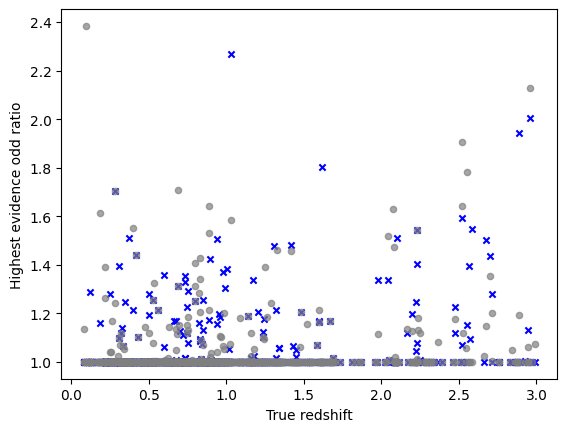

In [23]:
f,a=plt.subplots(1,1)
df_test_more.plot.scatter('True redshift', 'Highest evidence odd ratio', c='blue', marker='x', ax=a)
df_ref_more.plot.scatter('True redshift', 'Highest evidence odd ratio', c='grey', alpha=0.7, ax=a)

In [24]:
def zp_zs_plot(photo_z_df, x_series, y_series, outlier_lim_pct=15, hue=None):
    f,a=plt.subplots(1,1)
    if hue is None:
        df_to_plot = photo_z_df[[photo_z_df.columns[0], x_series, y_series]].copy()
        hue='outlier'
    else:
        df_to_plot = photo_z_df[[photo_z_df.columns[0], x_series, y_series, hue]].copy()
    df_to_plot['bias'] = df_to_plot[y_series]-df_to_plot[x_series]
    df_to_plot['scatter'] = np.abs(df_to_plot['bias']/(1.+df_to_plot[x_series]))
    df_to_plot['outlier'] = (df_to_plot['scatter'] > outlier_lim_pct/100)
    outl_rate = 100.0*len(df_to_plot[df_to_plot['outlier']])/len(df_to_plot)
    NMAD = 1.4821 * np.median(df_to_plot['scatter'])

    sns.scatterplot(data=df_to_plot, x=x_series, y=y_series, hue=hue, marker='.', ax=a)
    a.plot(df_to_plot[x_series].values, df_to_plot[x_series].values, c='k', ls=':', lw=0.5)
    a.plot(df_to_plot[x_series].values, outlier_lim_pct/100+(1.+outlier_lim_pct/100)*df_to_plot[x_series].values, c='k', lw=0.5)
    a.plot(df_to_plot[x_series].values, -outlier_lim_pct/100+(1.-outlier_lim_pct/100)*df_to_plot[x_series].values, c='k', lw=0.5)
    a.set_title("$z_{phot}$ vs. $z_{spec}$ : "+f"{outl_rate:.3f}% outliers @{outlier_lim_pct}% ; NMAD={NMAD:.4f}")
    
def which_is_best(photo_z_df):
    poss_src = np.array(['Photometric redshift', 'Highest evidence z_phot (mode)', 'Highest evidence z_phot (mean)'])
    bias_mode = np.abs(photo_z_df['bias'].values)
    bias_ev_mode = np.abs(photo_z_df['Highest evidence z_phot (mode)'].values - photo_z_df['True redshift'].values)
    bias_ev_mean = np.abs(photo_z_df['Highest evidence z_phot (mean)'].values - photo_z_df['True redshift'].values)
    
    best_pestim = []
    for m, ev_mo, ev_me in zip(bias_mode, bias_ev_mode, bias_ev_mean):
        order = np.argsort([m, ev_mo, ev_me])
        sorted_es = poss_src[order]
        best_pestim.append(sorted_es[0])
        '''
        if ev_me<ev_mo and ev_me<m :
            best_pestim.append('Highest evidence z_phot (mean)')
        elif ev_mo<m and ev_mo<ev_me :
            best_pestim.append('Highest evidence z_phot (mode)')
        else :
            assert (m<=ev_mo and m<=ev_me), "Error in logic."
            best_pestim.append('Photometric redshift')
        '''
                
    best_zp = [ photo_z_df.loc[photo_z_df.index[n], esti] for n,esti in enumerate(best_pestim) ]
    
    photo_z_df['Best estimator']=best_pestim
    photo_z_df['Best point estimate']=best_zp
    zp_zs_plot(photo_z_df, 'True redshift', 'Best point estimate', hue='Best estimator')
    

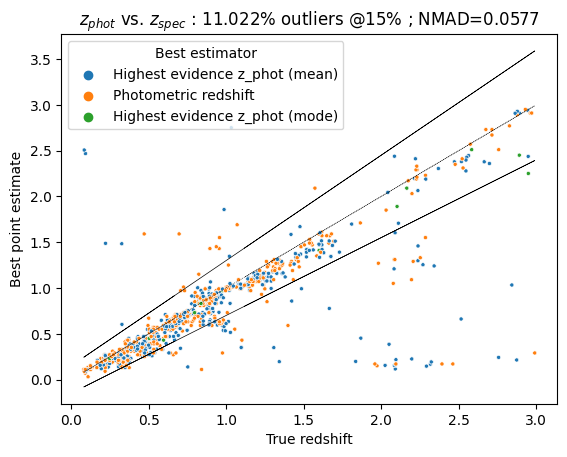

In [25]:
which_is_best(df_test_more)

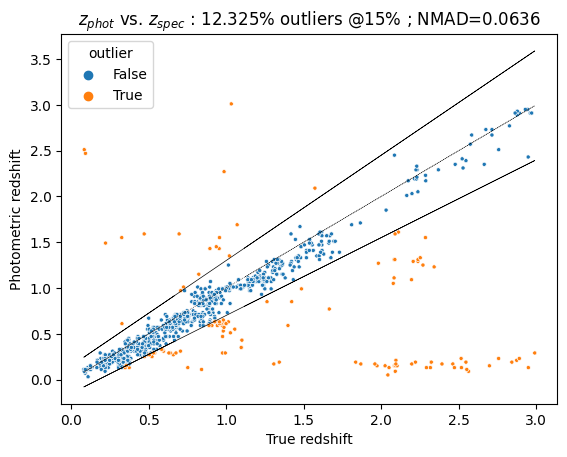

In [26]:
zp_zs_plot(df_test_more, 'True redshift', 'Photometric redshift')

In [27]:
bad_test_df = pd.DataFrame(posteriors_dict_test[bad_case]['5 best models at z_spec'])
bad_ref_df = pd.DataFrame(posteriors_dict_ref[bad_case]['5 best models at z_spec'])
bad_test_df

,Template SED,Dust law,E(B-V),zp (mode),average(z),sigma(z),median(z),Odd ratio,Bias,M(cosmos_u_cfht),M(cosmos_u_new),M(hsc_gHSC),M(hsc_rHSC),M(hsc_iHSC),M(hsc_zHSC),M(hsc_yHSC)
0,CWW_Im-id107,Calzetti,0.1,2.57,2.5469007,0.0031487243,2.59,0.6626445,0.001964628,25.077187,25.281593,24.445717,24.303581,24.238739,24.25193,24.228455
1,CWW_Im-id265,Calzetti,0.15,2.57,2.5534587,0.01118502,2.59,0.56992394,0.001964628,25.07,25.243912,24.45974,24.301964,24.243195,24.251877,24.219643
2,CWW_Im-id546,Prevot,0.05,2.59,2.580206,0.0037254163,2.61,0.608109,0.0075778696,25.043938,25.19178,24.4767,24.298904,24.24398,24.278328,24.258675
3,CWW_Im-id537,Calzetti,0.15,2.55,2.529912,0.0047060614,2.57,0.55720127,0.0036486138,25.083214,25.249,24.47329,24.299202,24.244652,24.236328,24.167099
4,CWW_Im-id107,Prevot,0.05,2.4099998,2.4452953,0.0046927882,2.47,1.3953192,0.042941373,25.13279,25.330482,24.484024,24.284111,24.209877,24.218086,24.20134


Text(0, 0.5, '$p(z|model)$')

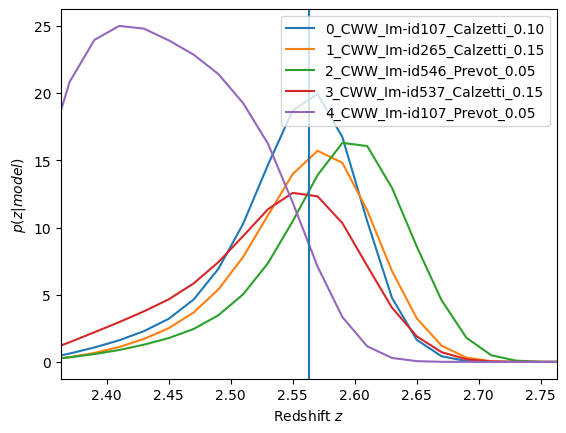

In [28]:
temp_names = np.array([test_inputs['Templates'][t]['name'] for t in test_inputs['Templates']])
posterior = posteriors_dict_test[bad_case]['Full posterior']
for item in bad_test_df.index :
    mod_num=np.argwhere(temp_names == bad_test_df.loc[item, 'Template SED'])[0][0]
    for idust, d in enumerate(dust_arr_test):
        if d.name==bad_test_df.loc[item, 'Dust law'] and d.EBV==bad_test_df.loc[item, 'E(B-V)'] : dust_num = idust
    z_num = np.argwhere(np.abs(z_grid_test-bad_test_df.loc[item, 'zp (mode)'])<test_inputs['Z_GRID']['z_step']/10)[0][0]
    #print(temp_names[mod_num])
    #print(dust_arr_test[dust_num])
    #print(z_grid_test[z_num])
    plt.plot(z_grid_test, posterior[mod_num, dust_num, :],\
             label=f"{item}_{bad_test_df.loc[item, 'Template SED']}_{bad_test_df.loc[item, 'Dust law']}_{bad_test_df.loc[item, 'E(B-V)']:.2f}")
plt.axvline(df_test_more.loc[bad_case, "True redshift"])
plt.xlim(df_test_more.loc[bad_case, "True redshift"]-0.2, df_test_more.loc[bad_case, "True redshift"]+0.2)
plt.legend()
plt.xlabel("Redshift $z$")
plt.ylabel("$p(z|model)$")

In [29]:
good_test_df = pd.DataFrame(posteriors_dict_test[good_case]['5 best models at z_spec'])
good_ref_df = pd.DataFrame(posteriors_dict_ref[good_case]['5 best models at z_spec'])
good_test_df

,Template SED,Dust law,E(B-V),zp (mode),average(z),sigma(z),median(z),Odd ratio,Bias,M(cosmos_u_cfht),M(cosmos_u_new),M(hsc_gHSC),M(hsc_rHSC),M(hsc_iHSC),M(hsc_zHSC),M(hsc_yHSC)
0,CWW_Im-id107,Prevot,0.05,2.27,2.2480843,0.044239633,2.29,0.59243196,0.012697395,24.981033,25.183846,24.535645,24.425468,24.39087,24.385109,24.38926
1,CWW_Im-id699,Prevot,0.1,2.27,2.2781193,0.002960786,2.31,0.3525411,0.012697395,24.982475,25.129059,24.542686,24.398415,24.39051,24.424309,24.448677
2,CWW_Im-id699,Calzetti,0.25,2.27,1.8765185,0.68620133,2.27,0.28014117,0.012697395,24.98201,25.160255,24.563332,24.428062,24.387512,24.370956,24.347725
3,CWW_Im-id546,Calzetti,0.15,2.25,2.2439232,0.002615909,2.27,0.14473306,0.006503533,24.995651,25.18937,24.560295,24.428703,24.39064,24.34542,24.294373
4,CWW_Im-id546,Prevot,0.05,2.33,2.282685,0.1676091,2.37,0.99999994,0.031278983,24.937798,25.100952,24.538078,24.435524,24.43895,24.436852,24.421196


Text(0, 0.5, '$p(z|model)$')

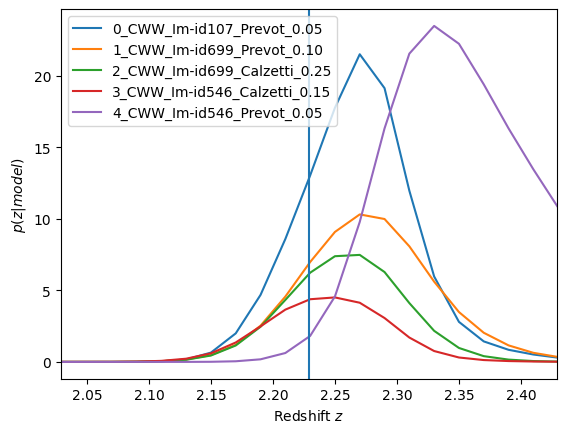

In [30]:
temp_names = np.array([test_inputs['Templates'][t]['name'] for t in test_inputs['Templates']])
posterior = posteriors_dict_test[good_case]['Full posterior']
for item in good_test_df.index :
    mod_num=np.argwhere(temp_names == good_test_df.loc[item, 'Template SED'])[0][0]
    for idust, d in enumerate(dust_arr_test):
        if d.name==good_test_df.loc[item, 'Dust law'] and d.EBV==good_test_df.loc[item, 'E(B-V)'] : dust_num = idust
    z_num = np.argwhere(np.abs(z_grid_test-good_test_df.loc[item, 'zp (mode)'])<test_inputs['Z_GRID']['z_step']/10)[0][0]
    plt.plot(z_grid_test, posterior[mod_num, dust_num, :],\
             label=f"{item}_{good_test_df.loc[item, 'Template SED']}_{good_test_df.loc[item, 'Dust law']}_{good_test_df.loc[item, 'E(B-V)']:.2f}")
plt.axvline(df_test_more.loc[good_case, "True redshift"])
plt.xlim(df_test_more.loc[good_case, "True redshift"]-0.2, df_test_more.loc[good_case, "True redshift"]+0.2)
plt.legend()
plt.xlabel("Redshift $z$")
plt.ylabel("$p(z|model)$")

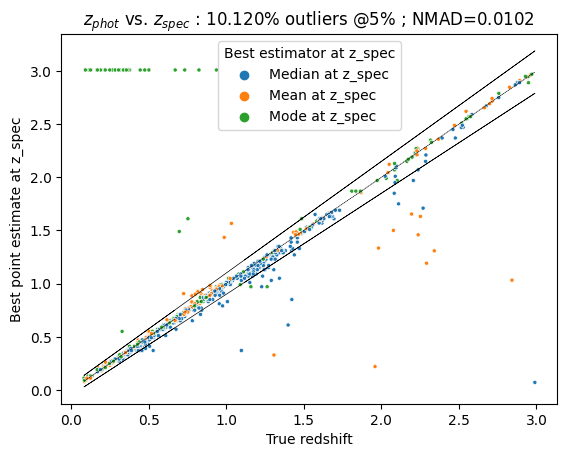

In [31]:
modes_zs = []
means_zs = []
meds_zs = []
best_estim_at_zs = []
best_zp_at_zs = []

for loc, _case in enumerate(df_test_more.index):
    posterior = posteriors_dict_test[_case]['Full posterior']
    good_test_df = pd.DataFrame(posteriors_dict_test[_case]['5 best models at z_spec'])
    
    mod_num=np.argwhere(temp_names == good_test_df.loc[0, 'Template SED'])[0][0]
    for idust, d in enumerate(dust_arr_test):
        if d.name==good_test_df.loc[0, 'Dust law'] and d.EBV==good_test_df.loc[0, 'E(B-V)'] : dust_num = idust
    z_num = np.argwhere(np.abs(z_grid_test-good_test_df.loc[0, 'zp (mode)'])<test_inputs['Z_GRID']['z_step']/10)[0][0]
    mode_at_zs = good_test_df.loc[0, 'zp (mode)']
    mean_at_zs = good_test_df.loc[0, 'average(z)']
    med_at_zs = good_test_df.loc[0, 'median(z)']
    tru_z = df_test_more.loc[_case, "True redshift"]
    
    poss_zp = np.array([mode_at_zs, mean_at_zs, med_at_zs])
    
    bias_mode = np.abs(mode_at_zs-tru_z)
    bias_mean = np.abs(mean_at_zs-tru_z)
    try :
        bias_med = np.abs(med_at_zs-tru_z)
    except TypeError:
        bias_med = 99
    
    poss_src = np.array(['Mode at z_spec', 'Mean at z_spec', 'Median at z_spec'])
    
    best_pestim = []

    order = np.argsort([bias_mode, bias_mean, bias_med])
    sorted_es = poss_src[order]
    sorted_zp = poss_zp[order]
    best_estim_at_zs.append(sorted_es[0])
    best_zp_at_zs.append(sorted_zp[0])
    
df_test_more['Best estimator at z_spec']=np.array(best_estim_at_zs)
df_test_more['Best point estimate at z_spec']=np.array(best_zp_at_zs)
zp_zs_plot(df_test_more, 'True redshift', 'Best point estimate at z_spec', outlier_lim_pct=5, hue='Best estimator at z_spec')

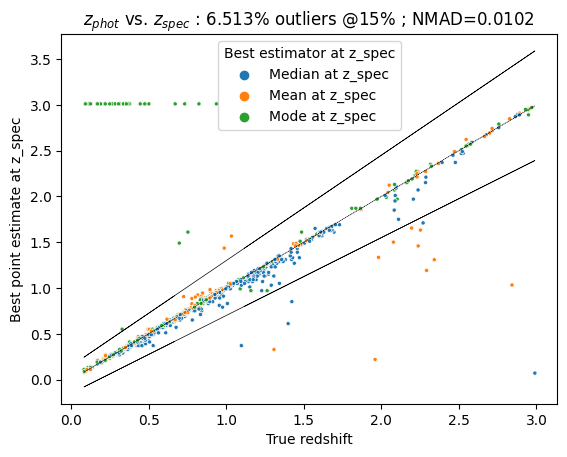

In [32]:
zp_zs_plot(df_test_more, 'True redshift', 'Best point estimate at z_spec', outlier_lim_pct=15, hue='Best estimator at z_spec')